# 학습 관련 기술들

이번 장에서 알아볼 내용
- 최적화 방법
- 가중치 매개변수 초깃값 (전에는 random으로 설정)
- 하이퍼파라미터 설정 방법 (node, lr, batch size....)
- 오버피팅 방지 (가중치 감소, 드랍아웃 등 정규화 방법)
- 배치 정규화

In [1]:
# 라이브러리
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)

# 매개변수 갱신

매개변수의 최적값을 찾는 이런 과정을 최적화(Optimization)라고 한다.

최적의 매개변수를 찾을 단서로 매개변수의 기울기(1.수치미분 2.오차역전파법)을 앞서 살펴봤음

GD의 수식

$W \leftarrow W - \eta\frac{\partial{L}}{\partial{W}}$

아래와 같이 구현하면 SGD의 인스턴스에 매개변수와 기울기 정보를 전달하면 매개변수가 update 

참고내용 Lasagne 프레임워크의 최적화 기법들 

https://github.com/Lasagne/Lasagne/blob/master/lasagne/updates.py

In [3]:
# Gradient Descent 구현

class SGD(object):
    def __init__(self, lr = 0.01):
        self.lr = lr  # 인스턴스 변수로 learning rate 

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD의 문제점

방향에 따라 기울기가 달라지는 함수에서는 탐색 경로가 비효율적이다.

따라서 개선된 최적화 기법을 살펴보자:
- 모멘텀(Momentum)
- AdaGrad(Adaptive Gradient)
- Adam


In [4]:
# 모멘텀
class Momentum(object):
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr # learning rate 
        self.momentum = momentum # 일반적으로 0.9 (따라서 default값 0.9)
        self.v = None # V(0) = 0

    def update(self, params, grads):
        if self.v is None: # 처음 갱신
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]     

In [5]:
# AdaGrad
class Adagrad(object):
    def __init__(self, lr = 0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None: # 처음 갱신
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

In [6]:
W1 = np.array([[1, 2], [3, 4]])
W2 = np.array([[2, 4], [6, 8]])
print(W1 * W2) # element wise

[[ 2  8]
 [18 32]]


RMSProp은

Adagrad의 식에서 $h$ 부분이 다름
$h_i \leftarrow ph + (1-p)\frac{\partial{L}}{\partial{W}}\odot\frac{\partial{L}}{\partial{W}}$

$p$ 값이 작을수록 최신 기울기를 많이 반영

In [7]:
# RMSProp
class RMSProp(object):
    def __init__(self, lr = 0.01, p = 0.9):
        self.lr = lr
        self.p = p # 추가
        self.h = None

    def update(self, params, grads):
        if self.h is None: # 처음 갱신
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] = self.p * self.h[key] + (1 - self.p) * (grads[key] * grads[key]) # 식 반영
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Adam ( https://arxiv.org/pdf/1412.6980v8.pdf )

AdaGrad + RMSProp 각각의 장점을 이용

성능은 아래와 같이 대부분의 경우에서 가장 좋음

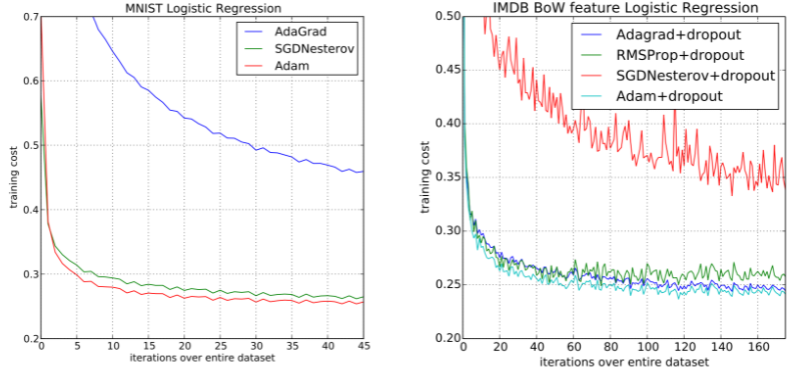

In [8]:
class Adam(object):
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999): # 논문에서 제시된 기본 값들로 default값 설정
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None: # 처음 갱신
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1

        # learning rate도 beta를 통해 조정하면 성능이 더 좋아진다.
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key] # Momentum
            self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2) # AdaGrad / RMSProp

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7) # AdaGrad / RMSProp

# 가중치의 초깃값

앞에서 가중치 초깃값은 랜덤으로 설정했었다.

하지만 가중치 초깃값도 신경망 학습에 영향을 끼치므로 어떤 식으로 설정하면 좋을지 확인

In [9]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

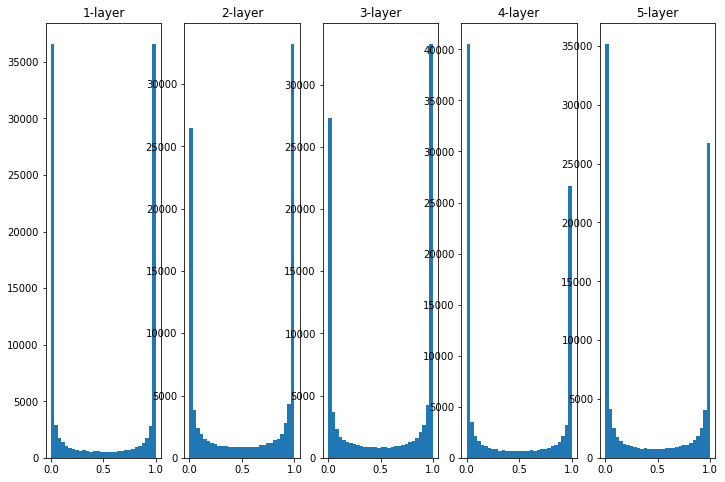

In [10]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

이번에는 가중치를 표준편차가 0.01인 정규분포로 바꿔서 실험

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01 # 표준편차 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

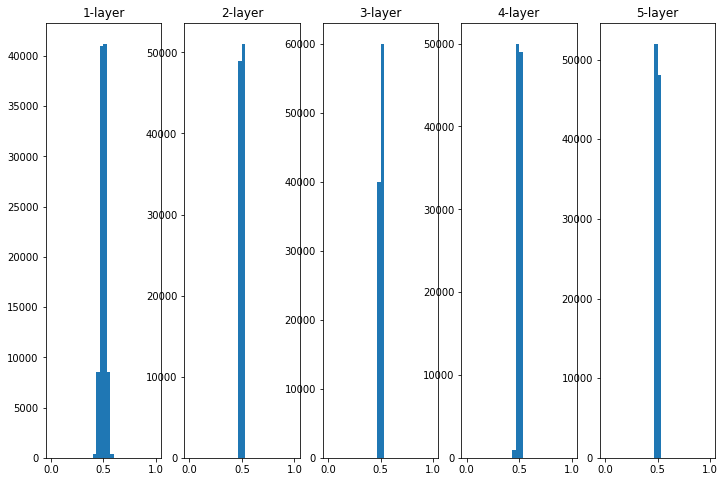

In [12]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

Xavier 초깃값을 사용해보자

Xavier 초깃값은 초깃값의 표준편차가 $\frac{1}{\sqrt{n}}$ 인 정규분포로 초기화

In [13]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    
    activations[i] = z

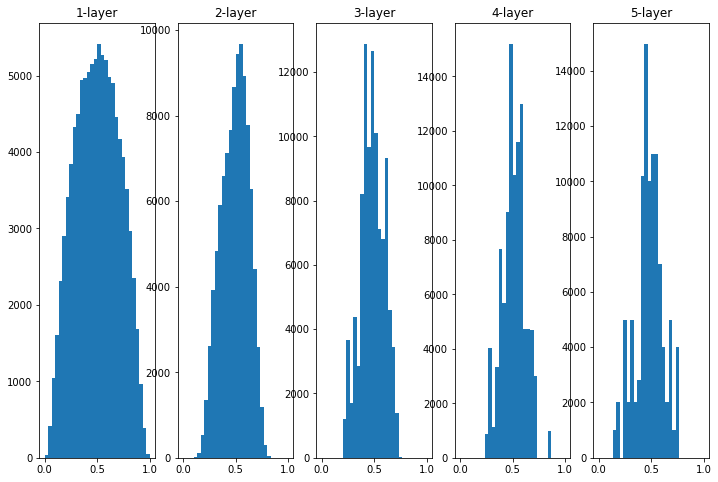

In [14]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

위에서 Xavier 초깃값을 사용해 이전보다 넓게 분포됨

하지만 층이 깊어지면서 형태가 다소 일그러진다.

tanh 함수를 활성화 함수로 사용해 개선해보자.

가중치를 단순히 표준편차가 0.01인 정규분포로 설정했을 때 tanh

In [15]:
def tanh(x):
    return np.tanh(x)

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01 # 표준편차 0.01
    a = np.dot(x, w)
    z = tanh(a)
    
    activations[i] = z

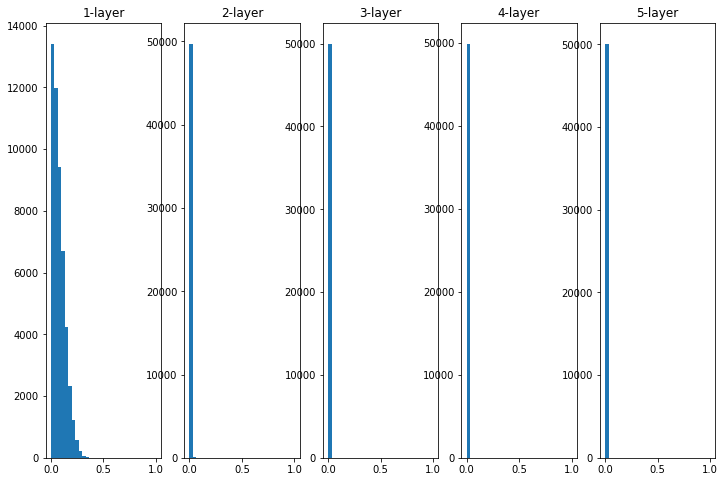

In [16]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

Xavier 초깃값을 사용했을 때

In [17]:
def tanh(x):
    return np.tanh(x)

x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = tanh(a)
    
    activations[i] = z

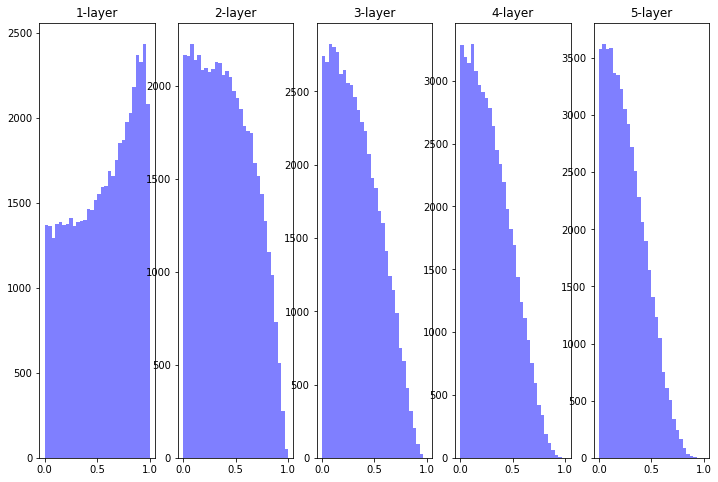

In [18]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1), alpha = 0.5, color = 'b')

plt.show()

Xavier 초깃값은 활성화 함수가 선형인 것을 전제로 이끈 결과.

sigmoid와 tanh함수는 좌우 대칭이라 중앙 부근이 선형인 함수로 볼 수 있다.

그래서 Xavier 초깃값이 적절했음

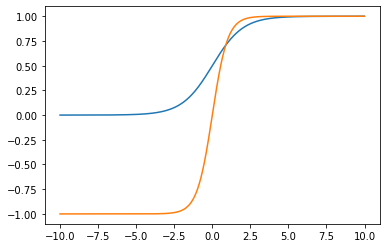

In [19]:
# 중앙 부근 선형?
x = np.arange(-10,10,0.01)

plt.plot(x,sigmoid(x))
plt.plot(x,tanh(x))
plt.show()

ReLU를 이용할 때는 ReLU에 특화된 초깃값을 이용하는 것이 권장된다.

이 초깃값은 He초깃값이다.

He초깃값은 앞 계층의 노드가 n개일 때, 표준편차 $\sigma = \sqrt{\frac{2}{n}}$ 인 정규분포를 사용한다.

ReLU를 활성화 함수로 이용할 때 Xavier 초깃값을 적용하면

계층이 깊어질수록, 가중치의 값이 0으로 수렴해 기울기 소실 문제를 일으키기 쉽다.

In [20]:
# ReLU를 활성화 함수로 사용할 때, Xavier 초깃값을 사용하는 경우
def Relu(x):
    return np.maximum(x, 0)
    
x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = Relu(a)
    
    activations[i] = z

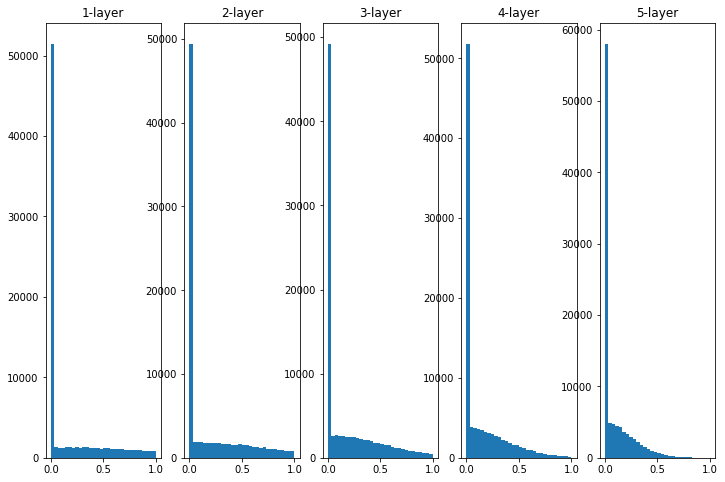

In [21]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

In [22]:
# ReLU를 활성화 함수로 사용할 때, Xavier 초깃값을 사용하는 경우
def Relu(x):
    return np.maximum(x, 0)
    
x = np.random.randn(1000, 100) 
node_num = 100 # 은닉층 노드 수
hidden_layer_size = 5 # 은닉층 5개

activations = {} # 층마다 출력 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * np.sqrt(2 / node_num)
    a = np.dot(x, w)
    z = Relu(a)
    
    activations[i] = z

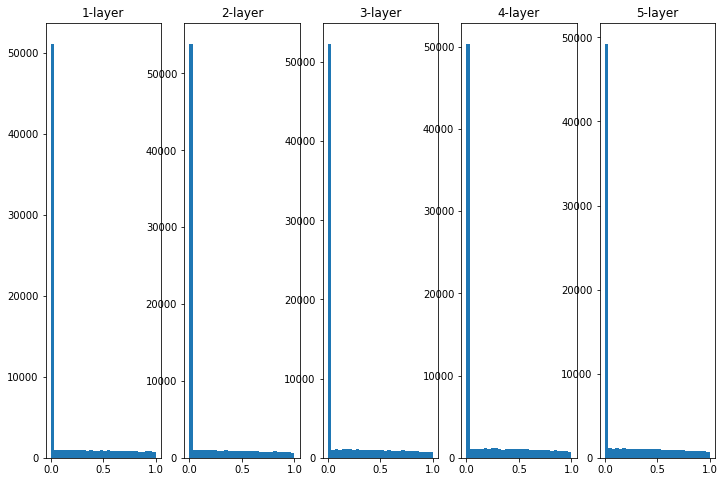

In [23]:
# 히스토그램 그리기
plt.figure(figsize=(12,8))

for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(f"{i+1}-layer")
    plt.hist(a.flatten(), 30, range=(0,1))

plt.show()

# 배치 정규화

- 배치 정규화는 단순하게 평균과 분산을 구하는 것이 아니라 감마(Scale), 베타(Shift) 를 통한 변환을 통해 비선형 성질을 유지 하면서 학습 될 수 있게 해준다.


- 배치 정규화가 신경망 레이어의 중간 중간에 위치하게 되어 학습을 통해 감마, 베타를 구할 수 있다. 


- Internal Covariate Shift 문제로 인해 신경망이 깊어질 경우 학습이 어려웠던 문제점을 해결

- gradient 의 스케일이나 초기 값에 대한 dependency 가 줄어들어 Large Learning Rate 를 설정할 수 있기 떄문에 결과적으로 빠른 학습 가능함, 즉, 기존 방법에서 learning rate 를 높게 잡을 경우 gradient 가 vanish/explode 하거나 local minima 에 빠지는 경향이 있었는데 이는 scale 때문이었으며, 배치 정규화를 사용할 경우 propagation 시 파라미터의 scale 에 영향을 받지 않게 되기 때문에 learning rate 를 높게 설정할 수 있는 것.

- regularization 효과가 있기 때문에 dropout 등의 기법을 사용하지 않아도 됨 (효과가 같기 때문)

- 학습 시 Deterministic 하지 않은 결과 생성 

- Learning Rate Decay 를 더 느리게 설정 가능

- 입력의 범위가 고정되기 때문에 saturating 한 함수를 활성화 함수로 써도 saturation 문제가 일어나지 않음 (여기서 saturation 문제란 가중치의 업데이트가 없어지는 현상)

============== 1/16 ==============
epoch:0 | 0.094 - 0.056


/content/drive/MyDrive/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.066
epoch:2 | 0.097 - 0.105
epoch:3 | 0.097 - 0.133
epoch:4 | 0.097 - 0.155
epoch:5 | 0.097 - 0.169
epoch:6 | 0.097 - 0.198
epoch:7 | 0.097 - 0.211
epoch:8 | 0.097 - 0.227
epoch:9 | 0.097 - 0.243
epoch:10 | 0.097 - 0.277
epoch:11 | 0.097 - 0.281
epoch:12 | 0.097 - 0.295
epoch:13 | 0.097 - 0.315
epoch:14 | 0.097 - 0.341
epoch:15 | 0.097 - 0.353
epoch:16 | 0.097 - 0.376
epoch:17 | 0.097 - 0.394
epoch:18 | 0.097 - 0.407


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.409
============== 2/16 ==============
epoch:0 | 0.092 - 0.103


/content/drive/MyDrive/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/MyDrive/deep-learning-from-scratch-master/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/deep-learning-from-scratch-master/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:1 | 0.097 - 0.116
epoch:2 | 0.097 - 0.136
epoch:3 | 0.097 - 0.155
epoch:4 | 0.097 - 0.184
epoch:5 | 0.097 - 0.204
epoch:6 | 0.097 - 0.228
epoch:7 | 0.097 - 0.251
epoch:8 | 0.097 - 0.274
epoch:9 | 0.097 - 0.303
epoch:10 | 0.097 - 0.321
epoch:11 | 0.097 - 0.344
epoch:12 | 0.097 - 0.366
epoch:13 | 0.097 - 0.376
epoch:14 | 0.097 - 0.389
epoch:15 | 0.097 - 0.414
epoch:16 | 0.097 - 0.424
epoch:17 | 0.097 - 0.446
epoch:18 | 0.097 - 0.46


No handles with labels found to put in legend.


epoch:19 | 0.097 - 0.465
============== 3/16 ==============
epoch:0 | 0.084 - 0.114
epoch:1 | 0.313 - 0.123
epoch:2 | 0.454 - 0.137
epoch:3 | 0.546 - 0.165
epoch:4 | 0.618 - 0.214
epoch:5 | 0.669 - 0.244
epoch:6 | 0.736 - 0.285
epoch:7 | 0.776 - 0.311
epoch:8 | 0.803 - 0.336
epoch:9 | 0.816 - 0.376
epoch:10 | 0.868 - 0.403
epoch:11 | 0.888 - 0.434
epoch:12 | 0.9 - 0.47
epoch:13 | 0.918 - 0.491
epoch:14 | 0.93 - 0.52
epoch:15 | 0.945 - 0.537
epoch:16 | 0.958 - 0.562
epoch:17 | 0.962 - 0.578
epoch:18 | 0.973 - 0.601


No handles with labels found to put in legend.


epoch:19 | 0.974 - 0.616
============== 4/16 ==============
epoch:0 | 0.094 - 0.109
epoch:1 | 0.246 - 0.139
epoch:2 | 0.381 - 0.26
epoch:3 | 0.478 - 0.34
epoch:4 | 0.562 - 0.403
epoch:5 | 0.61 - 0.469
epoch:6 | 0.621 - 0.522
epoch:7 | 0.688 - 0.566
epoch:8 | 0.711 - 0.598
epoch:9 | 0.733 - 0.637
epoch:10 | 0.741 - 0.67
epoch:11 | 0.775 - 0.695
epoch:12 | 0.766 - 0.73
epoch:13 | 0.8 - 0.742
epoch:14 | 0.806 - 0.757
epoch:15 | 0.82 - 0.78
epoch:16 | 0.81 - 0.784
epoch:17 | 0.833 - 0.803
epoch:18 | 0.844 - 0.813


No handles with labels found to put in legend.


epoch:19 | 0.855 - 0.819
============== 5/16 ==============
epoch:0 | 0.086 - 0.096
epoch:1 | 0.1 - 0.135
epoch:2 | 0.117 - 0.258
epoch:3 | 0.118 - 0.382
epoch:4 | 0.121 - 0.48
epoch:5 | 0.124 - 0.545
epoch:6 | 0.125 - 0.603
epoch:7 | 0.122 - 0.653
epoch:8 | 0.123 - 0.701
epoch:9 | 0.123 - 0.738
epoch:10 | 0.123 - 0.761
epoch:11 | 0.125 - 0.792
epoch:12 | 0.125 - 0.815
epoch:13 | 0.125 - 0.829
epoch:14 | 0.13 - 0.852
epoch:15 | 0.128 - 0.865
epoch:16 | 0.137 - 0.873
epoch:17 | 0.142 - 0.886
epoch:18 | 0.14 - 0.892


No handles with labels found to put in legend.


epoch:19 | 0.149 - 0.901
============== 6/16 ==============
epoch:0 | 0.121 - 0.119
epoch:1 | 0.097 - 0.176
epoch:2 | 0.117 - 0.425
epoch:3 | 0.117 - 0.581
epoch:4 | 0.117 - 0.661
epoch:5 | 0.109 - 0.724
epoch:6 | 0.116 - 0.767
epoch:7 | 0.117 - 0.795
epoch:8 | 0.117 - 0.823
epoch:9 | 0.117 - 0.834
epoch:10 | 0.117 - 0.849
epoch:11 | 0.117 - 0.867
epoch:12 | 0.117 - 0.883
epoch:13 | 0.117 - 0.893
epoch:14 | 0.117 - 0.903
epoch:15 | 0.117 - 0.916
epoch:16 | 0.117 - 0.928
epoch:17 | 0.117 - 0.935
epoch:18 | 0.117 - 0.943


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.949
============== 7/16 ==============
epoch:0 | 0.115 - 0.077
epoch:1 | 0.116 - 0.246
epoch:2 | 0.116 - 0.551
epoch:3 | 0.116 - 0.675
epoch:4 | 0.116 - 0.749
epoch:5 | 0.116 - 0.792
epoch:6 | 0.116 - 0.81
epoch:7 | 0.116 - 0.863
epoch:8 | 0.116 - 0.886
epoch:9 | 0.116 - 0.899
epoch:10 | 0.116 - 0.913
epoch:11 | 0.116 - 0.925
epoch:12 | 0.116 - 0.936
epoch:13 | 0.116 - 0.953
epoch:14 | 0.116 - 0.963
epoch:15 | 0.116 - 0.971
epoch:16 | 0.116 - 0.975
epoch:17 | 0.116 - 0.98
epoch:18 | 0.116 - 0.982


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.986
============== 8/16 ==============
epoch:0 | 0.094 - 0.092
epoch:1 | 0.117 - 0.489
epoch:2 | 0.117 - 0.706
epoch:3 | 0.117 - 0.78
epoch:4 | 0.117 - 0.826
epoch:5 | 0.117 - 0.837
epoch:6 | 0.117 - 0.876
epoch:7 | 0.117 - 0.911
epoch:8 | 0.117 - 0.944
epoch:9 | 0.117 - 0.967
epoch:10 | 0.117 - 0.977
epoch:11 | 0.117 - 0.982
epoch:12 | 0.117 - 0.989
epoch:13 | 0.117 - 0.989
epoch:14 | 0.117 - 0.996
epoch:15 | 0.117 - 0.996
epoch:16 | 0.117 - 0.997
epoch:17 | 0.117 - 0.997
epoch:18 | 0.117 - 0.998


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.998
============== 9/16 ==============
epoch:0 | 0.117 - 0.13
epoch:1 | 0.116 - 0.572
epoch:2 | 0.116 - 0.741
epoch:3 | 0.116 - 0.856
epoch:4 | 0.116 - 0.906
epoch:5 | 0.116 - 0.95
epoch:6 | 0.116 - 0.967
epoch:7 | 0.116 - 0.979
epoch:8 | 0.116 - 0.984
epoch:9 | 0.116 - 0.985
epoch:10 | 0.116 - 0.992
epoch:11 | 0.116 - 0.994
epoch:12 | 0.116 - 0.998
epoch:13 | 0.116 - 0.997
epoch:14 | 0.116 - 1.0
epoch:15 | 0.116 - 0.999
epoch:16 | 0.116 - 1.0
epoch:17 | 0.116 - 1.0
epoch:18 | 0.116 - 1.0


No handles with labels found to put in legend.


epoch:19 | 0.116 - 1.0
============== 10/16 ==============
epoch:0 | 0.116 - 0.135
epoch:1 | 0.116 - 0.569
epoch:2 | 0.116 - 0.735
epoch:3 | 0.116 - 0.772
epoch:4 | 0.116 - 0.819
epoch:5 | 0.116 - 0.848
epoch:6 | 0.116 - 0.874
epoch:7 | 0.116 - 0.907
epoch:8 | 0.116 - 0.916
epoch:9 | 0.116 - 0.974
epoch:10 | 0.116 - 0.988
epoch:11 | 0.116 - 0.971
epoch:12 | 0.116 - 0.97
epoch:13 | 0.116 - 0.992
epoch:14 | 0.116 - 0.995
epoch:15 | 0.116 - 0.995
epoch:16 | 0.116 - 0.998
epoch:17 | 0.116 - 0.998
epoch:18 | 0.116 - 0.992


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.999
============== 11/16 ==============
epoch:0 | 0.099 - 0.088
epoch:1 | 0.117 - 0.703
epoch:2 | 0.117 - 0.802
epoch:3 | 0.117 - 0.793
epoch:4 | 0.117 - 0.857
epoch:5 | 0.117 - 0.825
epoch:6 | 0.117 - 0.923
epoch:7 | 0.117 - 0.941
epoch:8 | 0.117 - 0.74
epoch:9 | 0.117 - 0.957
epoch:10 | 0.117 - 0.976
epoch:11 | 0.117 - 0.985
epoch:12 | 0.117 - 0.988
epoch:13 | 0.117 - 0.99
epoch:14 | 0.117 - 0.987
epoch:15 | 0.117 - 0.991
epoch:16 | 0.117 - 0.962
epoch:17 | 0.117 - 0.987
epoch:18 | 0.117 - 0.992


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.997
============== 12/16 ==============
epoch:0 | 0.093 - 0.163
epoch:1 | 0.116 - 0.537
epoch:2 | 0.116 - 0.6
epoch:3 | 0.116 - 0.668
epoch:4 | 0.116 - 0.695
epoch:5 | 0.116 - 0.761
epoch:6 | 0.116 - 0.793
epoch:7 | 0.116 - 0.732
epoch:8 | 0.116 - 0.768
epoch:9 | 0.116 - 0.761
epoch:10 | 0.116 - 0.868
epoch:11 | 0.116 - 0.849
epoch:12 | 0.116 - 0.869
epoch:13 | 0.116 - 0.881
epoch:14 | 0.116 - 0.89
epoch:15 | 0.116 - 0.892
epoch:16 | 0.116 - 0.893
epoch:17 | 0.116 - 0.894
epoch:18 | 0.116 - 0.897


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.898
============== 13/16 ==============
epoch:0 | 0.117 - 0.18
epoch:1 | 0.117 - 0.471
epoch:2 | 0.116 - 0.55
epoch:3 | 0.116 - 0.587
epoch:4 | 0.116 - 0.566
epoch:5 | 0.116 - 0.596
epoch:6 | 0.116 - 0.609
epoch:7 | 0.116 - 0.613
epoch:8 | 0.116 - 0.613
epoch:9 | 0.116 - 0.615
epoch:10 | 0.117 - 0.613
epoch:11 | 0.117 - 0.612
epoch:12 | 0.117 - 0.616
epoch:13 | 0.117 - 0.617
epoch:14 | 0.117 - 0.613
epoch:15 | 0.117 - 0.658
epoch:16 | 0.117 - 0.713
epoch:17 | 0.116 - 0.717
epoch:18 | 0.116 - 0.711


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.716
============== 14/16 ==============
epoch:0 | 0.117 - 0.184
epoch:1 | 0.116 - 0.364
epoch:2 | 0.117 - 0.487
epoch:3 | 0.117 - 0.482
epoch:4 | 0.117 - 0.501
epoch:5 | 0.117 - 0.506
epoch:6 | 0.116 - 0.505
epoch:7 | 0.116 - 0.509
epoch:8 | 0.116 - 0.506
epoch:9 | 0.116 - 0.507
epoch:10 | 0.116 - 0.485
epoch:11 | 0.116 - 0.512
epoch:12 | 0.117 - 0.51
epoch:13 | 0.117 - 0.502
epoch:14 | 0.116 - 0.511
epoch:15 | 0.116 - 0.509
epoch:16 | 0.116 - 0.512
epoch:17 | 0.117 - 0.51
epoch:18 | 0.116 - 0.511


No handles with labels found to put in legend.


epoch:19 | 0.116 - 0.512
============== 15/16 ==============
epoch:0 | 0.099 - 0.193
epoch:1 | 0.117 - 0.272
epoch:2 | 0.117 - 0.31
epoch:3 | 0.117 - 0.413
epoch:4 | 0.117 - 0.477
epoch:5 | 0.117 - 0.481
epoch:6 | 0.117 - 0.47
epoch:7 | 0.117 - 0.492
epoch:8 | 0.117 - 0.502
epoch:9 | 0.117 - 0.502
epoch:10 | 0.117 - 0.509
epoch:11 | 0.117 - 0.496
epoch:12 | 0.117 - 0.508
epoch:13 | 0.117 - 0.509
epoch:14 | 0.117 - 0.51
epoch:15 | 0.117 - 0.509
epoch:16 | 0.117 - 0.51
epoch:17 | 0.117 - 0.511
epoch:18 | 0.117 - 0.508


No handles with labels found to put in legend.


epoch:19 | 0.117 - 0.512
============== 16/16 ==============
epoch:0 | 0.117 - 0.166
epoch:1 | 0.105 - 0.3
epoch:2 | 0.116 - 0.376
epoch:3 | 0.116 - 0.399
epoch:4 | 0.116 - 0.406
epoch:5 | 0.116 - 0.402
epoch:6 | 0.117 - 0.41
epoch:7 | 0.117 - 0.415
epoch:8 | 0.117 - 0.424
epoch:9 | 0.117 - 0.424
epoch:10 | 0.117 - 0.427
epoch:11 | 0.117 - 0.416
epoch:12 | 0.117 - 0.424
epoch:13 | 0.117 - 0.425
epoch:14 | 0.117 - 0.427
epoch:15 | 0.117 - 0.425
epoch:16 | 0.117 - 0.431
epoch:17 | 0.117 - 0.43
epoch:18 | 0.117 - 0.429
epoch:19 | 0.117 - 0.433


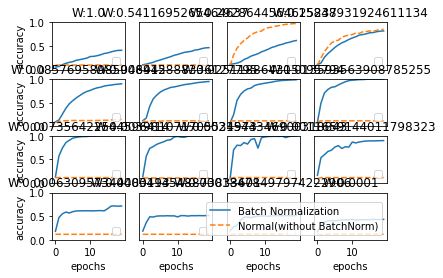

In [24]:
from ch06 import batch_norm_test

# 오버 피팅, 가중치 감소, 드롭아웃

오버피팅은 앞서 계속 말한거처럼 신경망이 훈련 데이터에만 지나치게 적응된 상태를 말한다.

주로 두 경우(둘 다 상대적으로 판단해야함)에 일어난다.
- 매개변수가 많고, 표현력이 높은 모델
- 훈련 데이터가 적을 때 

MNIST 데이터 셋에 대해 훈련 데이터를 적게 만들어서 오버피팅 예시를 보자.

In [25]:
from dataset.mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize = True)

# 학습 데이터 수 300으로 제한
x_train = x_train[:300]
t_train = t_train[:300] # 원 핫 인코딩 아님

In [26]:
from common.multi_layer_net import MultiLayerNet

network = MultiLayerNet(input_size = 784, hidden_size_list = [100, 100, 100, 100, 100, 100], output_size = 10)

optimizer = Adam(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

trian_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size/batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

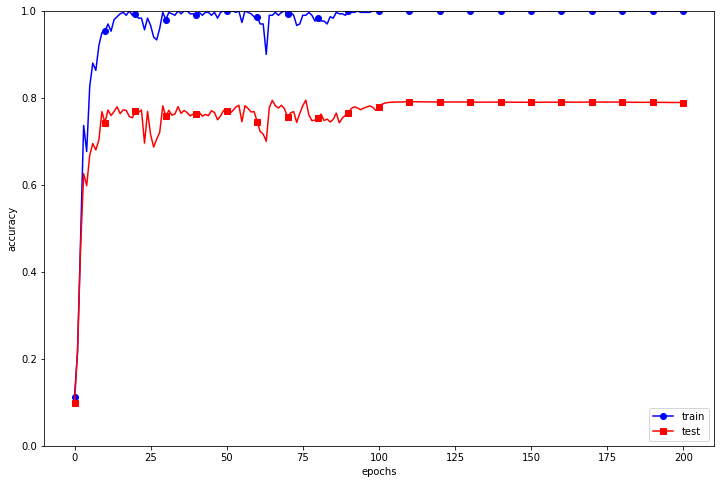

In [27]:
# 그래프 그리기
x = np.arange(max_epochs)

plt.figure(figsize = (12,8))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10,color = 'b')
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10, color = 'r')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

가중치 감소(weight decay)로 오버피팅 억제 가능

가중치 감소는 큰 가중치에 대해서 그에 맞는 패널티를 부여해 오버피팅을 억제하는 방법

$f(X) = W^TX$ 에서 가중치 벡터 값이 작을 경우 이 함수는 간단하다. 크면 복잡하다라고 보통 말함.

이 값은 $W^2$로 측정될 수 있고,이 값을 작게 유지하면 덜 복잡하니, 오버피팅을 좀 줄일 수 있다고 할 수 있음

이렇게 되면, 가중치 벡터 값이 너무 커지면 학습 알고리즘은 학습 오류를 최소화하는 것보다 $W$를 최소화 하려고 할 것.





Loss fucntion이 있다고 하자. ($L$)

그 Loss fucntion에 가중치의 제곱 노름을 더해주면 아래와 같다.

$L \leftarrow L + \frac{1}{2}\lambda W^2$

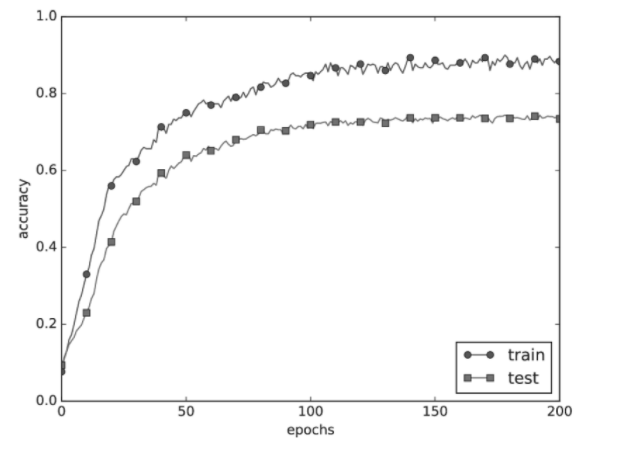

조금 나아진다.

드롭 아웃 (Drop Out)

노드를 임의로 삭제하면서 학습하는 방법.

가중치가 많아지면 많아질수록, (feature가 많아질수록)
overfit 될 가능성은 올라간다.

반대로, feature의 수가 적으면 당연히 overfit 되지 않겠지.



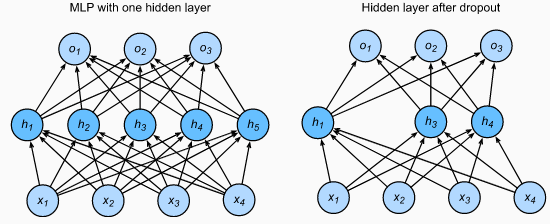

In [35]:
class Dropout(object):
    def __init__(sefl, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg = True):
        if train_flg: # 훈련 때
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        
        else: # 훈련 X
            return x * (1.0 - self.dropout_ratio)

    def backward(self,dout):
        return dout * self.mask

적용하면 아래와 같다. 

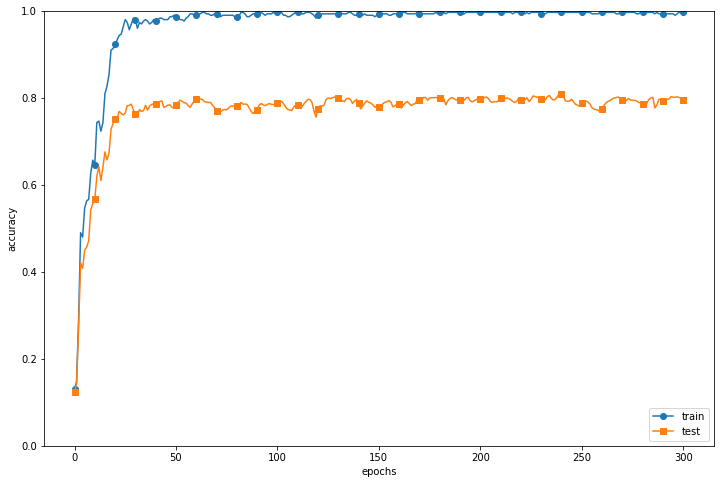

In [38]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비울 설정 ========================
use_dropout = True  # 드롭아웃을 쓰면 True
dropout_ratio = 0.3
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.01}, verbose=False)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.figure(figsize=(12,8))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [33]:
# 마스크는 이런 원리
x = np.array([[1, 2], [3, 4]])
print(x)

mask = np.random.rand(*x.shape) > 0.5
print(mask)
print(x * mask)

[[1 2]
 [3 4]]
[[False  True]
 [False  True]]
[[0 2]
 [0 4]]


# 적절한 하이퍼파라미터 값 찾기

하이퍼파라미터를 적절한 값으로 넣는 것도 중요한 요소

- 각 층 뉴런 수, 배치 크기
- 학습률 learning rate
- 가중치 감소에서 $\lambda$  값 등

이전에 데이터를 Train data, Test data로 나눴었다.

신경망을 학습시킬 때는 절대 Test data를 쓰면 안됐다. (오버피팅 됨)

따라서 Train data를 일정 비율로 나눠 Train data, Validation data로 나눈다.

In [41]:
# Train data : Validation data = 8 : 2 경우
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist()

# Train data를 섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

validation_rate = 0.2 # 검증 데이터 비율
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = x_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

하이퍼파라미터 최적화

하이퍼 파라미터는 하나하나 설정하려 하면 범위가 너무 넓다.

ex) 

learning rate = 0.001 ~ 0.01 까지도 0.0005 단위로 끊으면 ;;

node_num, batch_size도 설정하려면 경우의 수가 너무 많아짐 



따라서 랜덤으로 샘플링해 탐색하는 편이 좋다.